In [1]:
# load libraries used in script

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import scipy as scipy
from scipy.ndimage.interpolation import rotate

import os
from PIL import Image
#from PIL.ExifTags import TAGS, GPSTAGS

mpl.rcParams['font.family']='serif'
mpl.rcParams['font.size']=14


In [2]:
# define folders

# folder containing input images
inFolder = 'images/'

# folder where cutouts will be placed
cutouts = 'cutouts/'

# folder where derotated images will be placed
rotated = 'rotated/'

In [3]:
# read the image file names in folder
#  based on examples at https://realpython.com/working-with-files-in-python/#directory-listing-in-modern-python-versions

files = []
times = np.array([])

with os.scandir(inFolder) as dir_contents:
    for entry in dir_contents:
        info = entry.stat()
        files.append(entry.name)
        np.append(times,info.st_mtime)
        
        # check file names and that times are ascending
        print(entry.name, info.st_mtime)
        
# identify how many files are there
print(len(files))

IMG_7686.JPG 1503331688.0
IMG_7862.JPG 1503333658.0
IMG_8152.JPG 1503337182.0
IMG_8375.JPG 1503339540.0
4


################################
file number, name:  0 IMG_7686.JPG
dimensions, minimum, maximum:  (3024, 4032) 0 197
X value array dimensions, first row: (3024, 4032) [   0    1    2 ... 4029 4030 4031]
Y value array dimensions, first column: (3024, 4032) [   0    1    2 ... 3021 3022 3023]
test brightness selection, dimensions and nPoints: (3024, 4032) 1829723
min and max in X and Y: 1474 3016 509 2060
most extreme point on right:  3016 1285.0
most extreme point on left:  1474 1378.0
most extreme point on top:  2216.0 2060
most extreme point on bottom:  2216.5 509
sun center and radius:  2242.3008298755185 1286.7460179360194 773.7011402537441
 
################################
file number, name:  1 IMG_7862.JPG
dimensions, minimum, maximum:  (3024, 4032) 0 231
X value array dimensions, first row: (3024, 4032) [   0    1    2 ... 4029 4030 4031]
Y value array dimensions, first column: (3024, 4032) [   0    1    2 ... 3021 3022 3023]
test brightness selection, dimensions and nPoints: (

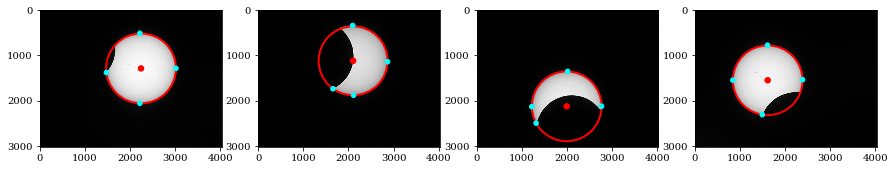

In [18]:
# Check process for identifying sun center
#  1)  identify extremes in X and Y
#  2)  use extremes to calculate circle center and radius

fig,ax = plt.subplots(1,4, figsize=(15, 15))

for i in np.arange(0,len(files)):

    print('################################')
    ##################################
    # load file
    filename = files[i]
    print("file number, name: ", i, files[i])
    im = Image.open(inFolder+filename)

    ##################################
    # make grayscale version of image
    grayIm = np.array(im.convert("L"))
    print("dimensions, minimum, maximum: ", np.shape(grayIm), np.min(grayIm), np.max(grayIm))
    
    #####################################
    # make array of X and Y values to use in calculations
    n_imcols = np.shape(grayIm)[1]
    n_imrows = np.shape(grayIm)[0]
    indices = np.indices((n_imrows,n_imcols))
    xs = indices[1,:]
    ys = indices[0,:]
    print('X value array dimensions, first row:', np.shape(xs), xs[0,:])
    print('Y value array dimensions, first column:', np.shape(ys), ys[:,0])
    
    #####################################
    # select points that include sunlight
    # brightness limit for source identification was selected by trial and error
    lim = 30
    whereHighBright = grayIm > lim
    print('test brightness selection, dimensions and nPoints:', np.shape(whereHighBright), np.sum(whereHighBright))

    #####################################
    # identify most extreme values in X and Y directions
    Xmax = np.max(xs[whereHighBright])
    Xmin = np.min(xs[whereHighBright])
    Ymax = np.max(ys[whereHighBright])
    Ymin = np.min(ys[whereHighBright])
    print('min and max in X and Y:', Xmin,Xmax,Ymin,Ymax)

    #####################################
    # identify most extreme points
    testLocation = (xs == Xmax)
    XmaxY = np.median(ys[testLocation * whereHighBright])
    print('most extreme point on right: ', Xmax, XmaxY)
    testLocation = (xs == Xmin)
    XminY = np.median(ys[testLocation * whereHighBright])
    print('most extreme point on left: ', Xmin, XminY)
    testLocation = (ys == Ymax)
    YmaxX = np.median(xs[testLocation * whereHighBright])
    print('most extreme point on top: ', YmaxX, Ymax)
    testLocation = (ys == Ymin)
    YminX = np.median(xs[testLocation * whereHighBright])
    print('most extreme point on bottom: ', YminX, Ymin)

    #####################################
    # use three points to figure out sun center and radius
    # point 1: Xmax, XmaxY
    # point 2: Xmin, XminY
    # point 3: YmaxX, Ymax
    A = Xmax * (XminY - Ymax) - XmaxY * (Xmin - YmaxX) + Xmin * Ymax - YmaxX * XminY
    B = (Xmax**2 + XmaxY**2)*(Ymax - XminY) + (Xmin**2 + XminY**2)*(XmaxY - Ymax) + (YmaxX**2 + Ymax**2)*(XminY-XmaxY)
    C = (Xmax**2 + XmaxY**2)*(Xmin - YmaxX) + (Xmin**2 + XminY**2)*(YmaxX - Xmax) + (YmaxX**2 + Ymax**2)*(Xmax-Xmin)
    D = (Xmax**2 + XmaxY**2)*(YmaxX*XminY - Xmin*Ymax) + (Xmin**2 + XminY**2)*(Xmax*Ymax - YmaxX*XmaxY) + (YmaxX**2 + Ymax**2)*(Xmin*XmaxY-Xmax*XminY)
    x0 = (-1.0) * B / (2*A)
    y0 = (-1.0) * C / (2*A)
    r = ((B**2 + C**2 - 4*A*D)/(4*A**2))**(0.5)
    print('sun center and radius: ', x0, y0, r)

    
    ax[i].set_aspect('equal')
    ax[i].imshow(grayIm,'gray')

    # draw a circle around the extremes of the sun
    circ = Circle((x0,y0),r,fill=False,linewidth=2,color='red')
    ax[i].add_patch(circ)
    # draw a circle at the center of the sun
    circ = Circle((x0,y0),50,fill=True,linewidth=2,color='red')
    ax[i].add_patch(circ)

    # draw dots at the extreme points
    circ = Circle((Xmax,XmaxY),50, color='cyan')
    ax[i].add_patch(circ)
    circ = Circle((Xmin,XminY),50, color='cyan')
    ax[i].add_patch(circ)
    circ = Circle((YmaxX,Ymax),50, color='cyan')
    ax[i].add_patch(circ)
    circ = Circle((YminX,Ymin),50, color='cyan')
    ax[i].add_patch(circ)

    print(' ')



In [35]:
# load each image, save cutout and rotated version
# rotation angles were set manually by matching sunpots to image from SDO archive
#  at https://sdo.gsfc.nasa.gov/assets/img/browse/2017/08/21/20170821_001500_1024_HMIIF.jpg

for i in np.arange(0,len(files)):

    #print('################################')
    ##################################
    # load file
    filename = files[i]
    #print("file number, name: ", i, files[i])
    im = Image.open(inFolder+filename)

    ##################################
    # make grayscale version of image
    grayIm = np.array(im.convert("L"))
    #print("dimensions, minimum, maximum: ", np.shape(grayIm), np.min(grayIm), np.max(grayIm))
    
    #####################################
    # make array of X and Y values to use in calculations
    n_imcols = np.shape(grayIm)[1]
    n_imrows = np.shape(grayIm)[0]
    indices = np.indices((n_imrows,n_imcols))
    xs = indices[1,:]
    ys = indices[0,:]
    #print('X value array dimensions, first row:', np.shape(xs), xs[0,:])
    #print('Y value array dimensions, first column:', np.shape(ys), ys[:,0])
    
    #####################################
    # select points that include sunlight
    # brightness limit for source identification was selected by trial and error
    lim = 30
    whereHighBright = grayIm > lim
    #print('test brightness selection, dimensions and nPoints:', np.shape(whereHighBright), np.sum(whereHighBright))

    #####################################
    # identify most extreme values in X and Y directions
    Xmax = np.max(xs[whereHighBright])
    Xmin = np.min(xs[whereHighBright])
    Ymax = np.max(ys[whereHighBright])
    Ymin = np.min(ys[whereHighBright])
    #print('min and max in X and Y:', Xmin,Xmax,Ymin,Ymax)

    #####################################
    # identify most extreme points
    testLocation = (xs == Xmax)
    XmaxY = np.median(ys[testLocation * whereHighBright])
    #print('most extreme point on right: ', Xmax, XmaxY)
    testLocation = (xs == Xmin)
    XminY = np.median(ys[testLocation * whereHighBright])
    #print('most extreme point on left: ', Xmin, XminY)
    testLocation = (ys == Ymax)
    YmaxX = np.median(xs[testLocation * whereHighBright])
    #print('most extreme point on top: ', YmaxX, Ymax)
    testLocation = (ys == Ymin)
    YminX = np.median(xs[testLocation * whereHighBright])
    #print('most extreme point on bottom: ', YminX, Ymin)

    #####################################
    # use three points to figure out sun center and radius
    # point 1: Xmax, XmaxY
    # point 2: Xmin, XminY
    # point 3: YmaxX, Ymax
    A = Xmax * (XminY - Ymax) - XmaxY * (Xmin - YmaxX) + Xmin * Ymax - YmaxX * XminY
    B = (Xmax**2 + XmaxY**2)*(Ymax - XminY) + (Xmin**2 + XminY**2)*(XmaxY - Ymax) + (YmaxX**2 + Ymax**2)*(XminY-XmaxY)
    C = (Xmax**2 + XmaxY**2)*(Xmin - YmaxX) + (Xmin**2 + XminY**2)*(YmaxX - Xmax) + (YmaxX**2 + Ymax**2)*(Xmax-Xmin)
    D = (Xmax**2 + XmaxY**2)*(YmaxX*XminY - Xmin*Ymax) + (Xmin**2 + XminY**2)*(Xmax*Ymax - YmaxX*XmaxY) + (YmaxX**2 + Ymax**2)*(Xmin*XmaxY-Xmax*XminY)
    x0 = (-1.0) * B / (2*A)
    y0 = (-1.0) * C / (2*A)
    r = ((B**2 + C**2 - 4*A*D)/(4*A**2))**(0.5)
    #print('sun center and radius: ', x0, y0, r)

    #####################################
    # cutout region around sun center, with a bit of extra space around the edge
    # save raw cutout and rotated image
    # rotation angles set by inspection of full set of images
    
    cutoutRadius = 1000
    
    print(i,filename,np.shape(im), int(y0-cutoutRadius),int(y0+cutoutRadius),int(x0-cutoutRadius),int(x0+cutoutRadius))
    if (int(y0-cutoutRadius) < 0) or (int(y0+cutoutRadius) > n_imrows) or (int(x0-cutoutRadius) < 0) or (int(x0+cutoutRadius) > n_imcols):
        print("cannot make cutout of ", filename)
    else:
        #imSlice = Image.fromarray(imarray[int(y0-1000):int(y0+1000),int(x0-1000):int(x0+1000),:])
        imSlice = im.crop((int(x0-1000),int(y0-1000),int(x0+1000),int(y0+1000)))
        imSlice.save(cutouts+'CUTOUT-'+filename+'.png')
        
        # set image rotation angles based on inspection of full set of images 
        if i <= 0:
            rotationAngle = 216.0
        elif i <= 1:
            rotationAngle = 212.0
        else:
            rotationAngle = 223.0
        
        imRot = imSlice.rotate(rotationAngle)
        #print(np.shape(imRot))
        imRot.save(rotated+'ROTATED-'+filename+'.png')
    


0 IMG_7686.JPG (3024, 4032, 3) 286 2286 1242 3242
1 IMG_7862.JPG (3024, 4032, 3) 117 2117 1103 3103
2 IMG_8152.JPG (3024, 4032, 3) 1126 3126 997 2997
cannot make cutout of  IMG_8152.JPG
3 IMG_8375.JPG (3024, 4032, 3) 548 2548 613 2613


In [ ]:
# images were assembled into full video using ffmpeg
#  ffmpeg -framerate 15 -pattern_type glob -i '*.png' -r 5 -vcodec libx264 eclipse.mp4